# Milestone 3 - Wiki-Wandering: A tale of luck or skill ? 

#### Librairies

In [1]:
import numpy as np
from collections import Counter
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import html
import urllib

import warnings
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### Auxiliary functions

In [2]:
from helper_functions import *

#### Reading data

In [3]:
data_path = './data/wikispeedia_paths-and-graph/'
article_path = './data/plaintext_articles/'

categories = read_tsv(data_path, 'categories')
articles = read_tsv(data_path, 'articles')
links = read_tsv(data_path, 'links', names=['source', 'target'])

finished_paths = pd.read_pickle('finished_paths_w_positions.df')
unfinished_paths = pd.read_pickle('unfinished_paths_w_positions.df')

## A first glimpse of Wikispeedia

Wikispeedia games consist in going from a source article to a target article as quickly as possible on a subset of Wikipedia articles. However, sometimes the target takes a long time to reach, or is not reached at all. 

In [4]:
all_paths = pd.concat([finished_paths, unfinished_paths])
#Completion is a binary variable equal to 1 if the path is finished, 0 otherwise
all_paths['Completion'] = [1]*len(finished_paths) + [0]*len(unfinished_paths) 

all_paths = all_paths.groupby('Completion') \
       .agg({'path':'size', 'durationInSec':'mean'}) \
       .rename(columns={'completion': 'Paths', 'path':'Count','durationInSec':'Average time played'}) \
       .reset_index()\
       .replace([0, 1], ['Unfinished', 'Finished'])
display(all_paths)

,Completion,Count,Average time played
0,Unfinished,24874,835.257940
1,Finished,51317,158.276049


As they try to reach their goals, players browse through various articles, organized into categories arbitrarily created by Wikipedia. 

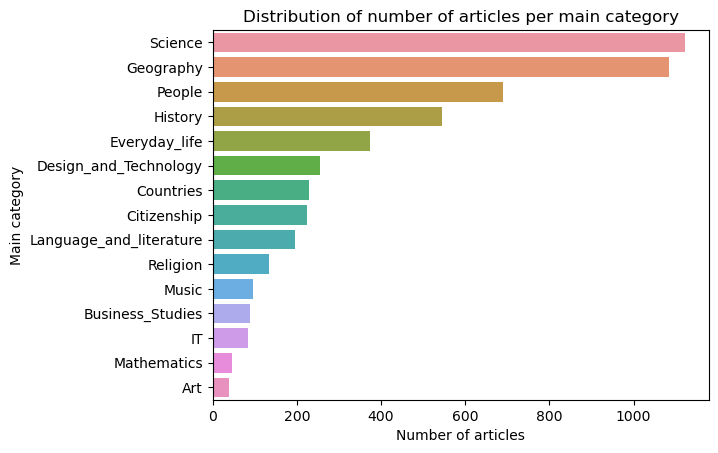

In [5]:
categories['main_category'] = categories['category'].str.split('.').str[1]
article_counts = categories['main_category'].value_counts()

sns.barplot(x=article_counts.values, y=article_counts.index, orient='horizontal')
plt.ylabel('Main category')
plt.xlabel('Number of articles')
plt.title('Distribution of number of articles per main category')
plt.show()

Let's see which category the top 100 articles visited fall into! 

In [6]:
all_paths = [i.split(';')[1:-1] for i in finished_paths['path'].tolist()]
all_articles = [article for path in all_paths for article in path]

article_counter = Counter(all_articles)
del article_counter['<']

# The 100 most visited articles and corresponding categories
top_hub_articles = [article for article, count in article_counter.most_common(100)]
top_hub_categories = categories[categories['article'].isin(top_hub_articles)]

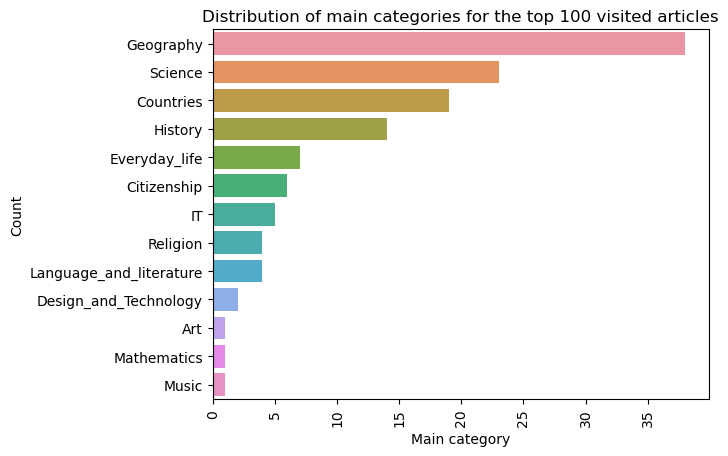

In [7]:
sns.countplot(data=top_hub_categories, y='main_category', order=top_hub_categories['main_category'].value_counts().index)
plt.xlabel('Main category')
plt.ylabel('Count')
plt.title('Distribution of main categories for the top 100 visited articles')
plt.xticks(rotation=90)
plt.show()

## Let us tell you about how you hunt for articles

### Part 1: Article Preferences

In this section, we look at the characteristics of article content that could affect the way a player interacts with article content. 

#### Ratio of input to output links

In [8]:
source_counts = links['source'].value_counts().rename_axis('article').reset_index(name='source_count')
target_counts = links['target'].value_counts().rename_axis('article').reset_index(name='target_count')

articles_features = pd.merge(source_counts, target_counts, how='outer')
articles_features.fillna(0, inplace=True)

articles_features['target_source_ratio'] = articles_features['target_count'] / articles_features['source_count']
articles_features['target_source_ratio'].replace([np.inf], np.nan, inplace=True)

#### Length of article

In [9]:
articles_features['article_length'] = articles_features['article'].apply(lambda x: article_length(article_path, x))

In [10]:
display(articles_features.head(5))

,article,source_count,target_count,target_source_ratio,article_length
0,United_States,294.0,1551.0,5.275510,9773
1,Driving_on_the_left_or_right,255.0,0.0,0.000000,7995
2,List_of_countries,244.0,63.0,0.258197,3162
3,List_of_circulating_currencies,236.0,8.0,0.033898,3019
4,List_of_sovereign_states,216.0,43.0,0.199074,5586


#### Position of links within the articles

In [11]:
# Remove links to and from non-Wikipedia articles (i.e. donation pages)
links = filter_rows_by_values(links, 'source', ['Friend_Directdebit', 'Sponsorship_Directdebit'])
links_targets = links.groupby('source')['target'].apply(list).reset_index()

# Add the 'html_position' column to the dataframe
links_targets['html_position'] = links_targets.apply(lambda row: find_html_position(row['source'], \
                                                                                    row['target']), axis=1);

In [12]:
m = pd.DataFrame([*links_targets['html_position']], links_targets.index).stack()\
      .rename_axis([None,'target']).reset_index(1, name='position')

links_positions = links_targets[['source']].join(m)
links_positions = pd.merge(links, links_positions, on=['source', 'target'], how='left')

In [13]:
display(links_positions.head(5))
links_positions.shape

,source,target,position
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,0.037459
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,0.025523
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,0.058024
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,0.032042
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man,0.063349


(119878, 3)

#### Level of category of the articles

The category level is defined by the number of sub-categories to which the article belongs. For example, if the article is referenced under only one main category, it's level is 1. If the article if referenced in a sub-category, it's level is 2, and so on. 

In [14]:
# Lists to store the name of the main, secondary and third categories
main_cats = []
sec_cats = []
thrd_cats = []
level = []

for cat in categories['category']:
    levels = cat.split('.')
    
    if len(levels) > 1:
        main_cats.append(levels[1])
        if len(levels) <= 2:
            sec_cats.append(np.nan)
            thrd_cats.append(np.nan)
            level.append(1)
        
    if len(levels) > 2:
        sec_cats.append(levels[2])
        if len(levels) <= 3:
            thrd_cats.append(np.nan)
            level.append(2)
            
    if len(levels) > 3:
        thrd_cats.append(levels[3])
        level.append(3)

categories['main_cat'] = main_cats
categories['sec_cat'] = sec_cats
categories['thr_cat'] = thrd_cats
categories['category_level'] = level

In [15]:
display(categories.head(5))

,article,category,main_category,main_cat,sec_cat,thr_cat,category_level
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures,People,People,Historical_figures,NaN,2
1,%C3%85land,subject.Countries,Countries,Countries,NaN,NaN,1
2,%C3%85land,subject.Geography.European_Geography.European_...,Geography,Geography,European_Geography,European_Countries,3
3,%C3%89douard_Manet,subject.People.Artists,People,People,Artists,NaN,2
4,%C3%89ire,subject.Countries,Countries,Countries,NaN,NaN,1


In [16]:
# Number of articles for each category level
article_cat_level = categories.groupby('category_level')['article'].count().reset_index()
display(article_cat_level)

,category_level,article
0,1,274
1,2,3448
2,3,1481


In [17]:
# Number of main, seconday and third categories
print(f'There are {len(np.unique(main_cats))} unique main categories, \
      {len(np.unique(sec_cats))-1} unique second level categories, \
      and {len(np.unique(thrd_cats))-1} unique third level categories.')

There are 15 unique main categories,       101 unique second level categories,       and 27 unique third level categories.


#### Visualization of the article characteristics

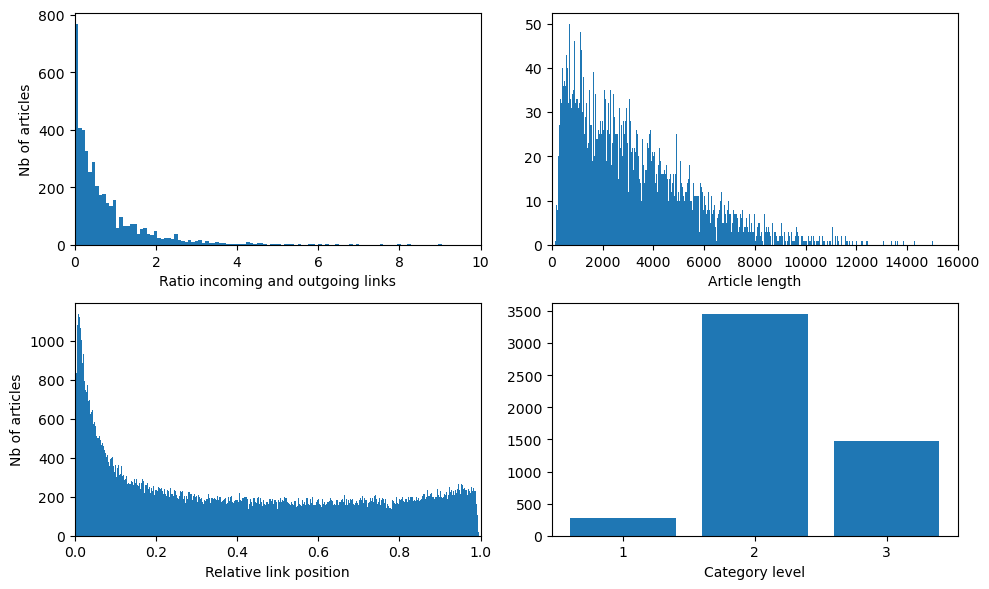

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Target source ratio
axs[0, 0].hist(articles_features['target_source_ratio'], bins=500);
axs[0, 0].set_xlim([0, 10])
axs[0, 0].set_ylabel('Nb of articles')
axs[0, 0].set_xlabel('Ratio incoming and outgoing links');

# Article length
axs[0, 1].hist(articles_features['article_length'], bins=500);
axs[0, 1].set_xlim([0, 16000])
axs[0, 1].set_xlabel('Article length');

# Link positions
axs[1, 0].hist(links_positions['position'], bins=500);
axs[1, 0].set_xlim([0, 1])
axs[1, 0].set_ylabel('Nb of articles')
axs[1, 0].set_xlabel('Relative link position');

# Category level
axs[1, 1].bar(['1', '2', '3'], article_cat_level['article']);
axs[1, 1].set_xlabel('Category level');

fig.tight_layout()

#### Distribution of average link positions

Let's see if players are more likely to click on a link at the top of a page or if they like to delve deeper into the articles. 

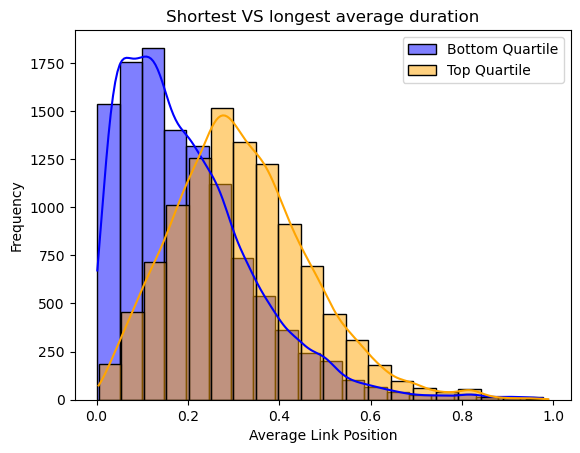

In [19]:
bottom_25_threshold = finished_paths['avg_duration'].quantile(0.25)
top_25_threshold = finished_paths['avg_duration'].quantile(0.75)

bottom_quartile_positions = finished_paths[finished_paths['avg_duration'] <= bottom_25_threshold]['avg_position']
top_quartile_positions = finished_paths[finished_paths['avg_duration'] >= top_25_threshold]['avg_position']

sns.histplot(bottom_quartile_positions, bins=20, kde=True, label='Bottom Quartile', color='blue', alpha=0.5)
sns.histplot(top_quartile_positions, bins=20, kde=True, label='Top Quartile', color='orange', alpha=0.5)

plt.xlabel('Average Link Position')
plt.ylabel('Frequency')
plt.title('Shortest VS longest average duration')

plt.legend()
plt.show()

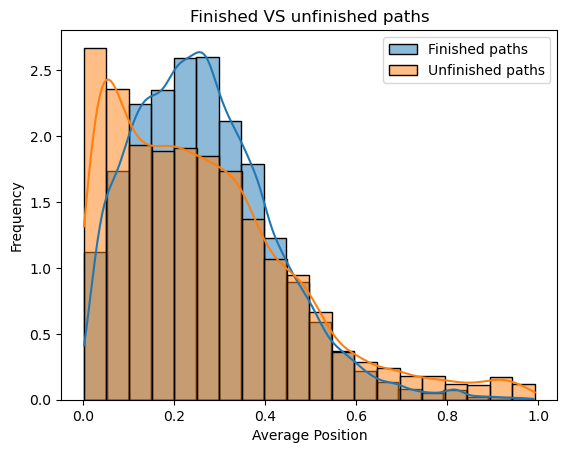

In [20]:
sns.histplot(data=finished_paths, x='avg_position', label='Finished paths', bins=20, kde=True, stat='density')
sns.histplot(data=unfinished_paths, x='avg_position', label='Unfinished paths', bins=20, kde=True, stat='density')

plt.xlabel('Average Position')
plt.ylabel('Frequency')
plt.title('Finished VS unfinished paths')

plt.legend()
plt.show()

### Part 2: Network Preferences

In this section, we investigate the article network to see whether players choose articles that exhibit certain network characteristics. 

In [21]:
# Create graph of Wikispeedia with nodes being articles and edges being links
G_link = nx.from_pandas_edgelist(links, 'source', 'target', create_using=nx.DiGraph())

#### Centralities

The *degree centrality* is used to measure the importance of a node in a network according to the number of connections it has. The *betweenness centrality* indicates the extent to which a node is on the shortest paths between other nodes in the network. The *closeness centrality* shows the average proximity of a node to all other nodes in the network. The *eigenvector centrality* gives importance to a node according to its connections with other important nodes. 

In [22]:
degree_centrality_links = get_degree_centrality(G_link)
betweenness_centrality_links = get_betweenness_centrality(G_link)
closeness_centrality_links = get_closeness_centrality(G_link)
eigenvector_centrality_links = get_eigenvector_centrality(G_link)

In [23]:
centrality_df_links = pd.DataFrame({
    'Node': list(G_link.nodes()),
    'Degree Centrality': [degree_centrality_links[node] for node in G_link.nodes()],
    'Betweenness Centrality': [betweenness_centrality_links[node] for node in G_link.nodes()],
    'Closeness Centrality': [closeness_centrality_links[node] for node in G_link.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality_links[node] for node in G_link.nodes()]
})
display(centrality_df_links.head(5))

,Node,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,0.002180,0.000000,0.000000,4.240661e-24
1,Columba,0.005013,0.000041,0.331956,1.851423e-03
2,D%C3%A1l_Riata,0.006975,0.000054,0.313141,9.743453e-04
3,Great_Britain,0.046861,0.002786,0.453960,4.398665e-02
4,Ireland,0.085004,0.005541,0.458459,4.318552e-02


#### Directed clustering coefficient

The *directed clustering coefficient* quantifies the likelihood that neighbors of a node are also connected to each other. 

In [24]:
directed_clustering_coefficient = nx.clustering(G_link)
directed_clustering_values = list(directed_clustering_coefficient.values())

In [25]:
# Convert the dictionary to a Series, aligning on the index with the DataFrame 'Node' column
clustering_coefficients_series = pd.Series(directed_clustering_coefficient)

# Set the 'Node' column as the index for proper alignment
centrality_df_links.set_index('Node', inplace=True)

# Add the Series as a new column to the DataFrame
centrality_df_links['Directed Clustering Coefficients'] = clustering_coefficients_series

# Reset the index if you want 'Node' to be a column again
centrality_df_links.reset_index(inplace=True)

#### Visualization of each centrality measure

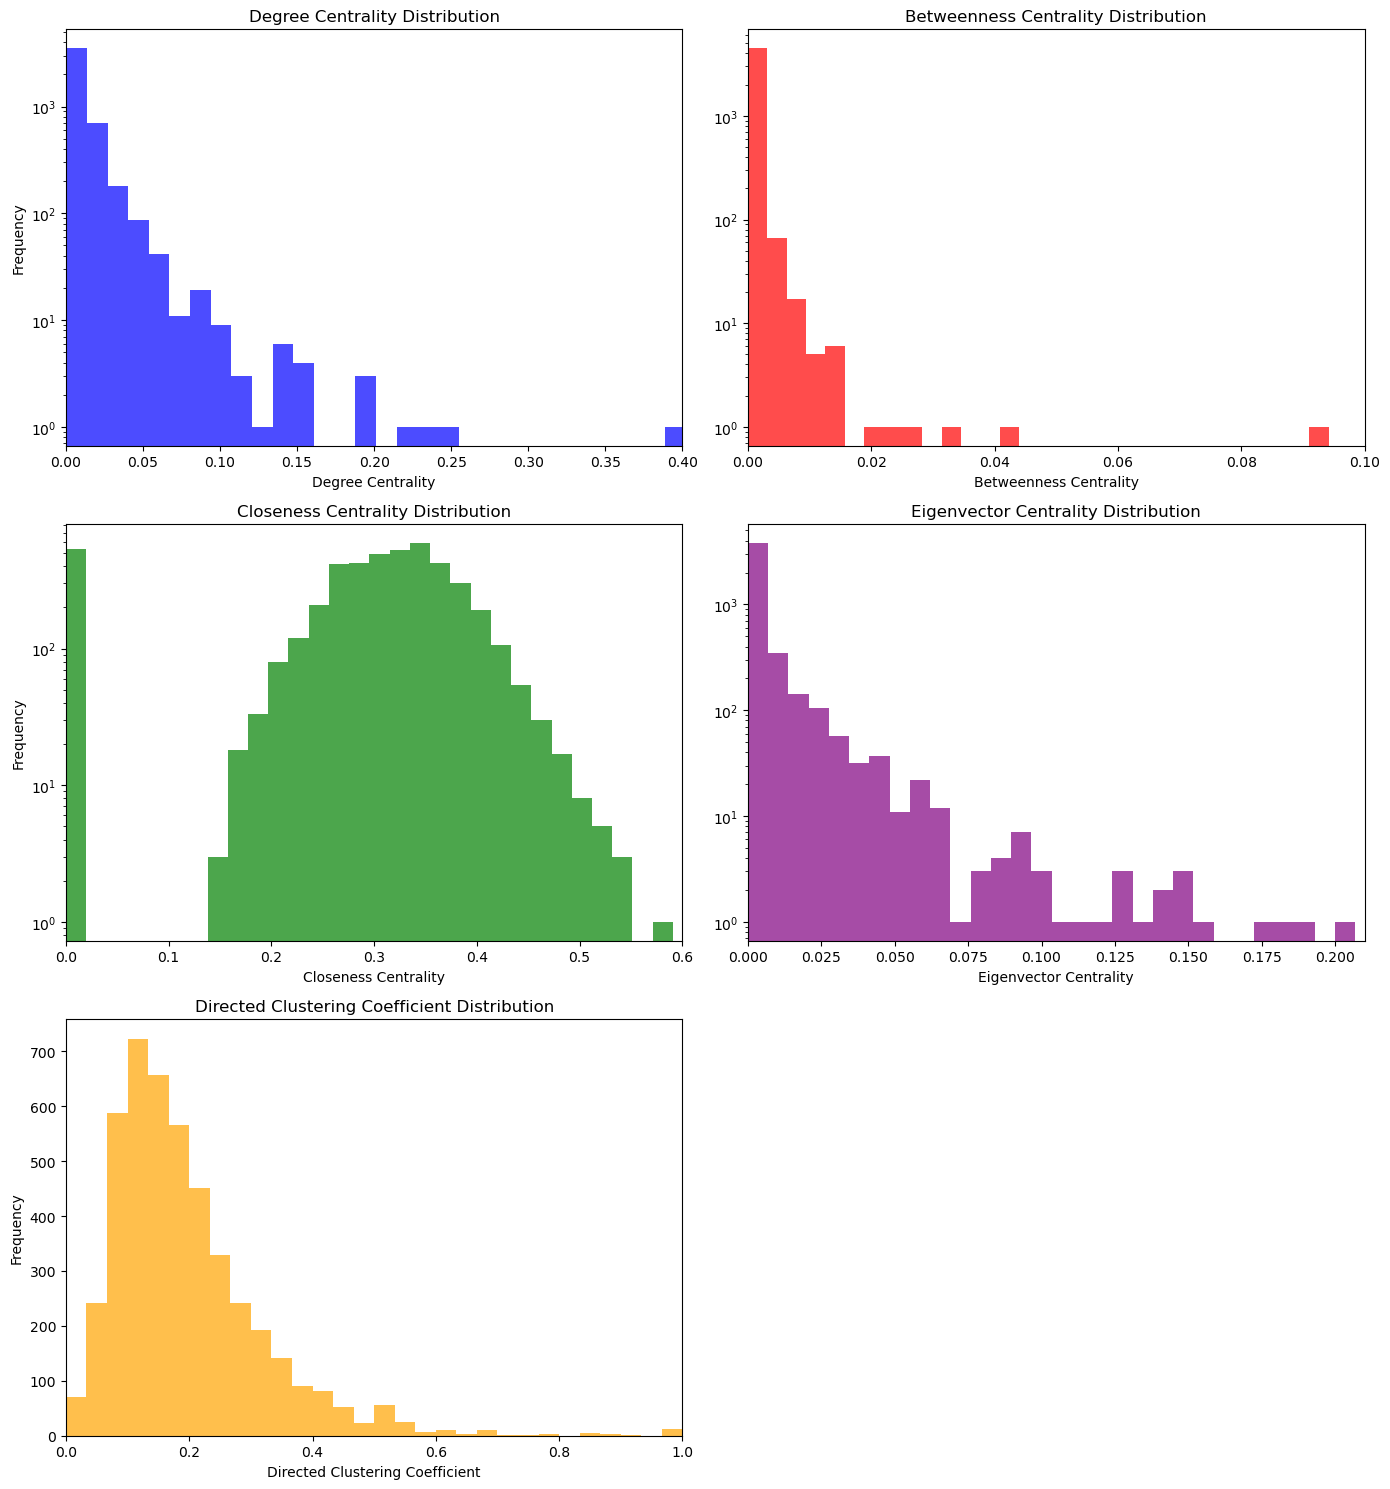

In [26]:
# Set the size of the overall figure
plt.figure(figsize=(14, 15))

# Degree Centrality Distribution
plt.subplot(3, 2, 1)
plt.hist(centrality_df_links['Degree Centrality'], bins=30, color='blue', alpha=0.7,log=True)
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.xlim([0, 0.4])
plt.ylabel('Frequency')

# Betweenness Centrality Distribution
plt.subplot(3, 2, 2)
plt.hist(centrality_df_links['Betweenness Centrality'], bins=30, color='red', alpha=0.7,log=True)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')
plt.xlim([0, 0.1])

# Closeness Centrality Distribution
plt.subplot(3, 2, 3)
plt.hist(centrality_df_links['Closeness Centrality'], bins=30, color='green', alpha=0.7, log=True)
plt.title('Closeness Centrality Distribution')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.xlim([0, 0.6])

# Eigenvector Centrality Distribution
plt.subplot(3, 2, 4)
plt.hist(centrality_df_links['Eigenvector Centrality'], bins=30, color='purple', alpha=0.7, log=True)
plt.title('Eigenvector Centrality Distribution')
plt.xlabel('Eigenvector Centrality')
plt.xlim([0, 0.21])

# Directed Clustering Coefficient Distribution
plt.subplot(3, 2, 5)  # Adjust to a 3x2 subplot grid
plt.hist(directed_clustering_values, bins=30, color='orange', alpha=0.7)
plt.title('Directed Clustering Coefficient Distribution')
plt.xlabel('Directed Clustering Coefficient')
plt.xlim([0, 1])
plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#### Distribution in paths taken by the players

In [119]:
# completion is the binary variable: 1 if finished, 0 otherwise
finished_paths['completion'] = 1
unfinished_paths['completion'] = 0

# get the end target article for finished_paths
finished_paths['target'] = finished_paths['path'].apply(lambda x: x.split(';')[-1])

# all paths by players
df_player = pd.concat([finished_paths, unfinished_paths], ignore_index=True, sort=False)

# split the paths
df_player['path'] = df_player['path'].apply(lambda x: x.split(';'))

# get the starting article
df_player['source'] = df_player['path'].apply(lambda x: x[0])

In [122]:
#ignore backtracks
filtered_paths = df_player[~df_player['path'].str.contains('<', regex=False)]

In [124]:
# graphs weighted by the number of times players click a particular link
weighted_graph = nx.DiGraph()
edge_weights = {}

for _, row in filtered_paths.iterrows():
    path = row['path']

    for i in range(len(path) - 1):
        source = path[i]
        target = path[i + 1]

        if not weighted_graph.has_edge(source, target):
            weighted_graph.add_edge(source, target, weight=1)
            edge_weights[(source, target)] = 1
        else:
            edge_weights[(source, target)] += 1
            weighted_graph[source][target]['weight'] = edge_weights[(source, target)]

Weighted Graph: 4169 nodes, 51102 edges


In [126]:
# graph properties
num_nodes = weighted_graph.number_of_nodes()
num_edges = weighted_graph.number_of_edges()

weighted_avg_degree = sum(d for n, d in weighted_graph.degree(weight='weight')) / num_nodes if num_nodes > 0 else 0

graph_density = nx.density(weighted_graph)
avg_clustering_coef = nx.average_clustering(weighted_graph)

strongly_connected = nx.is_strongly_connected(weighted_graph)
weakly_connected = nx.is_weakly_connected(weighted_graph)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average weighted degree: {weighted_avg_degree}")
print(f"Graph density: {graph_density}")
print(f"Average clustering coefficient: {avg_clustering_coef}")
print(f"Strongly connected: {strongly_connected}")
print(f"Weakly connected: {weakly_connected}")


Number of nodes: 4169
Number of edges: 51102
Average weighted degree: 121.94195250659631
Graph density: 0.0029408866927035254
Average clustering coefficient: 0.1961430734572837
Strongly connected: False
Weakly connected: True


In [127]:
# unweighted graph
# Create an unweighted graph
unweighted_graph = weighted_graph.copy()
for u, v, data in unweighted_graph.edges(data=True):
    data['weight'] = 1  
unweighted_degree = dict(unweighted_graph.degree())

# Calculate the average unweighted degree
average_unweighted_degree = sum(unweighted_degree.values()) / len(unweighted_degree)

print(f"Average Unweighted Degree: {average_unweighted_degree}")


Average Unweighted Degree: 24.515231470376587


In [130]:
# get the nodes most frequented (i.e. with most weighted degrees)
degrees = dict(weighted_graph.degree(weighted_graph.nodes()))
top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:200]
subgraph = unweighted_graph.subgraph(top_nodes)

# calculate centrality measures
degree_centrality = nx.degree_centrality(subgraph)
betweenness_centrality = nx.betweenness_centrality(subgraph)
closeness_centrality = nx.closeness_centrality(subgraph)
eigenvector_centrality = nx.eigenvector_centrality(subgraph)


In [131]:


#all_degree_centrality = nx.degree_centrality(unweighted_graph)
#all_betweenness_centrality = nx.betweenness_centrality(unweighted_graph)
#all_closeness_centrality = nx.closeness_centrality(unweighted_graph)
#all_eigenvector_centrality = nx.eigenvector_centrality(unweighted_graph)
import pickle
with open('centrality_data.pkl', 'rb') as file:
    loaded_centrality_data = pickle.load(file)

all_degree_centrality = loaded_centrality_data['degree_centrality']
all_betweenness_centrality = loaded_centrality_data['betweenness_centrality']
all_closeness_centrality = loaded_centrality_data['closeness_centrality']
all_eigenvector_centrality = loaded_centrality_data['eigenvector_centrality']


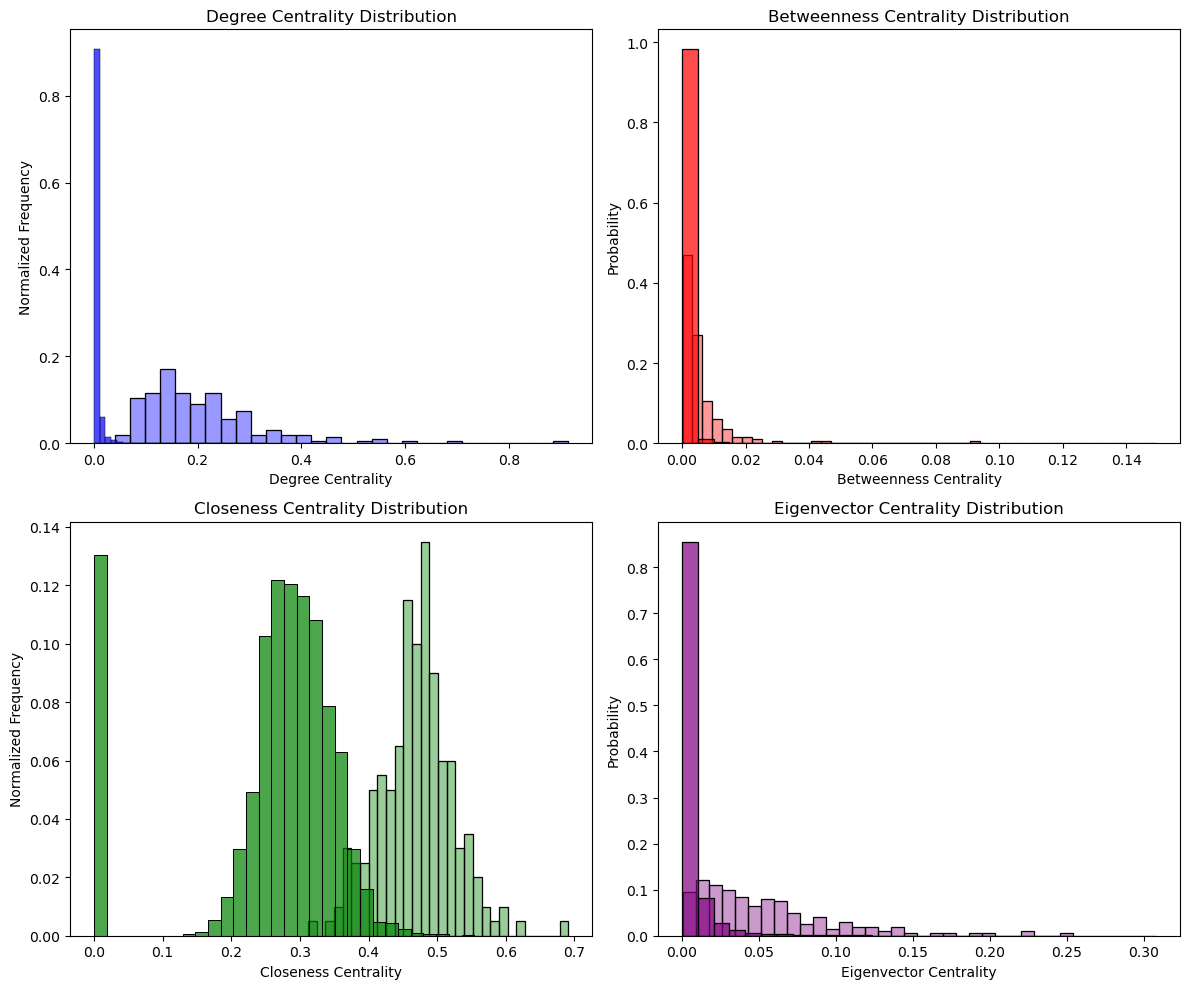

In [148]:

plt.figure(figsize=(12, 10))

# Degree centrality
plt.subplot(2, 2, 1)
sns.histplot(degree_centrality_values, bins=30, color='blue', alpha=0.4, stat='probability')
sns.histplot(all_degree_centrality_values, bins=30, color='blue', alpha=0.7, stat='probability')
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Normalized Frequency')

# Betweenness  
plt.subplot(2, 2, 2)
sns.histplot(betweenness_centrality_values, bins=30, color='red', alpha=0.4, stat='probability')
sns.histplot(all_betweenness_centrality_values, bins=30, color='red', alpha=0.7, stat='probability')
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')

# Closeness 
plt.subplot(2, 2, 3)
sns.histplot(closeness_centrality_values, bins=30, color='green', alpha=0.4, stat='probability')
sns.histplot(all_closeness_centrality_values, bins=30, color='green', alpha=0.7, stat='probability')
plt.title('Closeness Centrality Distribution')
plt.xlabel('Closeness Centrality')
plt.ylabel('Normalized Frequency')

# Eigenvector centrality
plt.subplot(2, 2, 4)
sns.histplot(eigenvector_centrality_values, bins=30, color='purple', alpha=0.4, stat='probability')
sns.histplot(all_eigenvector_centrality_values, bins=30, color='purple', alpha=0.7, stat='probability')
plt.title('Eigenvector Centrality Distribution')
plt.xlabel('Eigenvector Centrality')

plt.tight_layout()
plt.show()


### Part 3: Wikipedia Category Preferences

Here, we look at Wikipedia's category organization to see if it could have any influence on the network charateristics. The idea is to see whether the existing categories in our subset of Wikipedia reflect the optimal shortest paths and/or the path actually taken by players. 

In [162]:
G_link = nx.from_pandas_edgelist(links, 'source', 'target', create_using=nx.DiGraph())

overall_nodes = G_link.number_of_nodes()
overall_edges = G_link.number_of_edges()

overall_strong_connect = nx.is_strongly_connected(G_link)
overall_weak_connect = nx.is_weakly_connected(G_link)

print(f"Number of nodes: {overall_nodes}")
print(f"Number of edges: {overall_edges}")

# reachable from any node to any node
print(f"Strongly connected? {'Yes' if overall_strong_connect else 'No'}")
# all nodes connected regardless of direction
print(f"Weakly connected? {'Yes' if overall_weak_connect else 'No'}") 

# degree Distribution
degrees = [G_link.degree(n) for n in G_link.nodes()]
overall_avg_deg = sum(degrees) / len(degrees)
print(f"Average degree: {overall_avg_deg}")


# clustering coefficient
overall_density = nx.density(G_link)
overall_avg_cc = nx.average_clustering(G_link)
print(f"Graph density: {overall_density}")
print(f"Average clustering coefficient: {overall_avg_cc}")

Number of nodes: 4589
Number of edges: 119878
Strongly connected? No
Weakly connected? Yes
Average degree: 52.2458051863151
Graph density: 0.005693745116206964
Average clustering coefficient: 0.19526262419097987


In [166]:
# Get unique categories from 'main_category'
unique_categories = categories['main_category'].unique()
category_data = pd.DataFrame(columns=['category', 'nodes', 'edges',
                                      'avg_degree', 'density', 'clustering_coefficient',
                                      'strongly_connected', 'weakly_connected'])

category_data = category_data._append({
        'category': 'Overall/Average', 
        'nodes': overall_nodes, 
        'edges': overall_edges, 
        'avg_degree': overall_avg_deg/2, 
        'density': overall_density, 
        'clustering_coefficient': overall_avg_cc,
        'strongly_connected': overall_strong_connect,
        'weakly_connected': overall_weak_connect,
}, ignore_index=True)

# Iterate over each category and perform the analysis
for category in unique_categories:
    print(f"Analysis for Category: {category}")

    # Filter articles for the current category
    category_articles = categories[categories['main_category'] == category]['Node']
    filtered_links = links[links['source'].isin(category_articles) & links['target'].isin(category_articles)]

    # Create a sub-network for the current category
    G_category = nx.from_pandas_edgelist(filtered_links, 'source', 'target', create_using=nx.DiGraph())

    # Perform analysis on the sub-network
    num_nodes = G_category.number_of_nodes()
    num_edges = G_category.number_of_edges()
    avg_degree = sum(dict(G_category.degree()).values()) / num_nodes if num_nodes > 0 else 0
    graph_density = nx.density(G_category)
    avg_clustering_coef = nx.average_clustering(G_category)
    
    strongly_connected = nx.is_strongly_connected(G_category)
    weakly_connected = nx.is_weakly_connected(G_category)
    
    category_data = category_data._append({
        'category': category, 
        'nodes': num_nodes, 
        'edges': num_edges, 
        'avg_degree': avg_degree/2, 
        'density': graph_density, 
        'clustering_coefficient': avg_clustering_coef,
        'strongly_connected': strongly_connected,
        'weakly_connected': weakly_connected,
    }, ignore_index=True)

Analysis for Category: People
Analysis for Category: Countries
Analysis for Category: Geography
Analysis for Category: History
Analysis for Category: Business_Studies
Analysis for Category: Science
Analysis for Category: Everyday_life
Analysis for Category: Design_and_Technology
Analysis for Category: Music
Analysis for Category: IT
Analysis for Category: Language_and_literature
Analysis for Category: Mathematics
Analysis for Category: Religion
Analysis for Category: Art
Analysis for Category: Citizenship


In [167]:
# Compute averages 
category_data.at[0, 'nodes'] = category_data.at[0, 'nodes'] / 15
category_data.at[0, 'edges'] = category_data.at[0, 'edges'] / 15

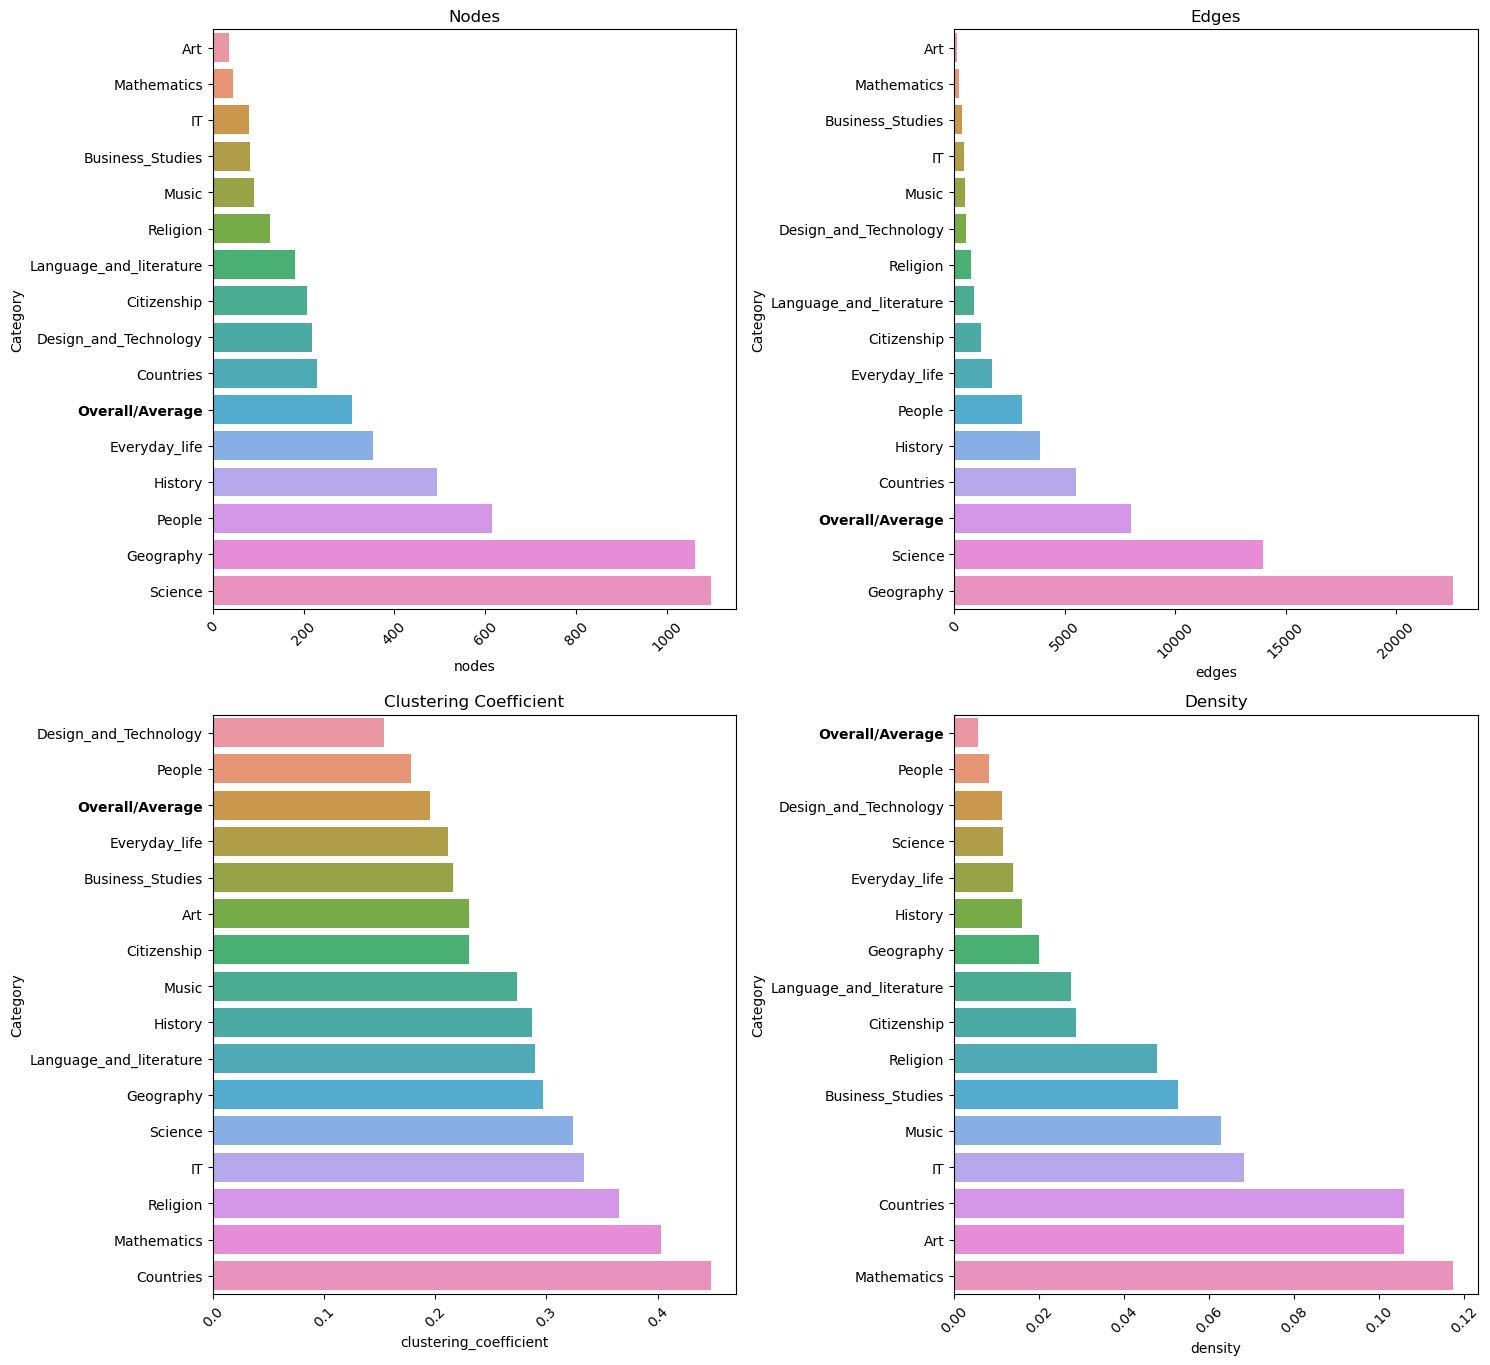

In [168]:
# Visualization of the number of nodes and edges in each category, 
# as well as the clustering coeff. and the density
properties = ['nodes', 'edges', 'clustering_coefficient', 'density']

plt.figure(figsize=(15, 20))

for i, prop in enumerate(properties, 1):
    plt.subplot(3, 2, i)  
    sorted_data = category_data.sort_values(by=prop, ascending=True)
    sns.barplot(y='category', x=prop, data=sorted_data)
    for lab in plt.gca().get_yticklabels():
        if lab.get_text() == "Overall/Average":
            lab.set_fontweight('bold')
    
    title_txt = f'{prop.replace("_", " ").title()}'
    plt.title(title_txt)
    plt.ylabel('Category')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Finding information on Wikipedia: a game of strategy, good architecture or mere luck ?

### Part 1: What the articles say

 Can we find out whether the characteristics of the article - the ratio between inbound and outbound links, the length or position of the links - actually affect the player's game, in terms of completion and average duration of the game?

#### Model 1: Logistic regression with `completion`

In [180]:
# Standardize the countinuous features
paths_normalized = df_player.copy()
paths_normalized['avg_article_length'] = normalize(df_player, 'avg_article_length')
paths_normalized['avg_position'] = normalize(df_player, 'avg_position')
paths_normalized['avg_target_source_ratio'] = normalize(df_player, 'avg_target_source_ratio')

# Drop NaN in features columns
paths_normalized = paths_normalized.dropna(subset=['avg_article_length', 'avg_position', \
                                                   'avg_target_source_ratio'])

In [181]:
# Logistic model
mod = smf.logit(formula = 'completion ~ avg_article_length + avg_position + avg_target_source_ratio',
                data = paths_normalized)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.565335
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             completion   No. Observations:                56710
Model:                          Logit   Df Residuals:                    56706
Method:                           MLE   Df Model:                            3
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                0.002341
Time:                        13:45:14   Log-Likelihood:                -32060.
converged:                       True   LL-Null:                       -32135.
Covariance Type:            nonrobust   LLR p-value:                 2.127e-32
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.0873      0.010    111.560      0.000       1.068   

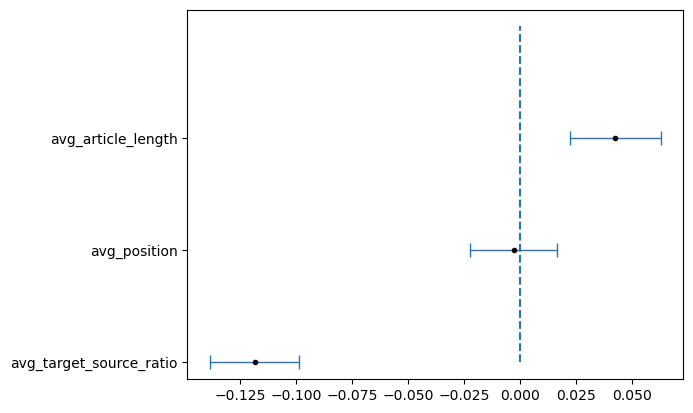

In [182]:
# Visualization of the contribution of each feature
variables = res.params.index
coefficients = res.params.values
p_values = res.pvalues
standard_errors = res.bse.values

l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))



plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)
plt.vlines(0,0, len(l1), linestyle = '--')
plt.yticks(range(len(l2)),l2)
fig.tight_layout()

#### Model 2: Linear regression with `log_avg_duration`

In [183]:
# Take the log of the avg_duration (to improve the normality of the residuals)
paths_normalized['log_avg_duration'] = np.log(paths_normalized['avg_duration'])

In [184]:
# Linear regression
mod = smf.ols(formula='log_avg_duration ~  avg_article_length + avg_position + avg_target_source_ratio', 
              data=paths_normalized)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       log_avg_duration   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     400.6
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          1.58e-257
Time:                        13:45:17   Log-Likelihood:                -90248.
No. Observations:               56710   AIC:                         1.805e+05
Df Residuals:                   56706   BIC:                         1.805e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

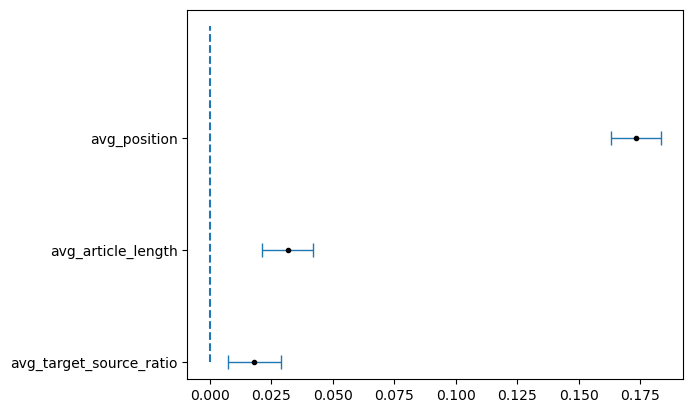

In [185]:
# Contribution of each features
variables = res.params.index
coefficients = res.params.values
p_values = res.pvalues
standard_errors = res.bse.values

l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)
plt.vlines(0,0, len(l1), linestyle = '--')
plt.yticks(range(len(l2)),l2)
fig.tight_layout()

### Part 2: What the network say

In this part, we want to see whether having more than one type of hub centrality in a player's path affects the time it takes to reach the target. Therefore, only finished paths are considered here. 

#### Create sets of hubs

In [218]:
# Calculate standard deviation for each centrality measure
std_devs = centrality_df_links.iloc[:, 1:-1].std()

# Add new columns indicating whether the node's centrality is above the standard deviation (1 if it is, 0 if not)
for centrality_measure in ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality', 'Directed Clustering Coefficients']:
    centrality_df_links[centrality_measure + ' Above Std'] = (
        centrality_df_links[centrality_measure] > std_devs[centrality_measure]).astype(int)
 

In [219]:
hubs_degree = set(centrality_df_links[centrality_df_links['Degree Centrality Above Std'] == 1]['Node'])
hubs_betweenness = set(centrality_df_links[centrality_df_links['Betweenness Centrality Above Std'] == 1]['Node'])
hubs_closeness = set(centrality_df_links[centrality_df_links['Closeness Centrality Above Std'] == 1]['Node'])
hubs_eigenvector = set(centrality_df_links[centrality_df_links['Eigenvector Centrality Above Std'] == 1]['Node'])
hubs_clustering = set(centrality_df_links[centrality_df_links['Directed Clustering Coefficients Above Std'] == 1]['Node'])

# Add the hub count columns to df_player
df_player['Degree Hub Count'] = df_player['path'].apply(lambda path: count_hubs(path, hubs_degree))
df_player['Betweenness Hub Count'] = df_player['path'].apply(lambda path: count_hubs(path, hubs_betweenness))
df_player['Closeness Hub Count'] = df_player['path'].apply(lambda path: count_hubs(path, hubs_closeness))
df_player['Eigenvector Hub Count'] = df_player['path'].apply(lambda path: count_hubs(path, hubs_eigenvector))
df_player['Clustering Hub Count'] = df_player['path'].apply(lambda path: count_hubs(path, hubs_clustering))

#### Get the shortest path between two articles

In [220]:
df_player['shortest_path'] = df_player.apply(lambda row: calculate_shortest_path_length(row, G_link), axis=1)
df_player['path_length'] = df_player['path'].apply(lambda x: len(x.split(';')))

#### Count the number of different categories

In [221]:
# Rename 'article' column to 'Node'
categories.rename(columns={'article': 'Node'}, inplace=True)

# Extract the last category element
categories['category'] = categories['category'].apply(lambda x: x.split('.')[-1] if pd.notnull(x) else None)

# Create a mapping from 'Node' to 'category'
category_mapping = categories.set_index('Node')['category'].to_dict()

# Map the category to the corresponding node in 'centrality_df_links'
centrality_df_links['category'] = centrality_df_links['Node'].map(category_mapping)

In [222]:
def count_unique_categories(path, node_to_category):
    if pd.isna(path):
        return 0
    # Split the path into nodes.
    nodes = path.split(';')
    # Find the category for each node, count unique categories.
    categories = [node_to_category.get(node) for node in nodes if node in node_to_category]
    return len(set(categories))


In [235]:
# Create a mapping from nodes to categories
node_to_category = pd.Series(centrality_df_links['category'].values, index=centrality_df_links['Node']).to_dict()

# Get the number of unique categories along the paths
df_player['unique_categories'] = df_player['path'].apply(lambda x: count_unique_categories(x, node_to_category))

In [241]:
df_player.columns = df_player.columns.str.replace(' ', '_')

hub_counts = ["Degree_Hub_Count", "Betweenness_Hub_Count", "Closeness_Hub_Count", 
              "Eigenvector_Hub_Count", "Clustering_Hub_Count"]

for hub_count in hub_counts:
    df_player[hub_count + "_Percentage"] = df_player[hub_count] / df_player['path_length']

coefficients = pd.DataFrame(columns=['coefficient'])

#### Linear regression with `completion`

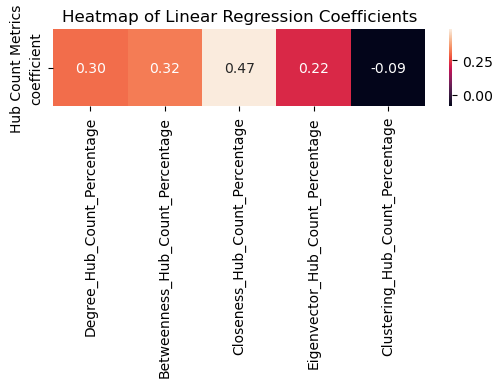

In [242]:
# Visualization of the contribution of coefficients
for hub_count in hub_counts:
    model = smf.ols(f"completion ~ {hub_count}_Percentage", df_player[df_player.completion<=1])
    result = model.fit()
    coefficients.loc[f'{hub_count}_Percentage', 'coefficient'] = result.params[f'{hub_count}_Percentage']
coefficients['coefficient'] = coefficients['coefficient'].astype(float)
coefficients_finish = coefficients
plt.figure(figsize=(6, 1))
sns.heatmap(coefficients.transpose(), annot=True, fmt=".2f")
plt.title('Heatmap of Linear Regression Coefficients')
plt.ylabel('Hub Count Metrics')
plt.show()

#### Linear regression with `durationInSec`

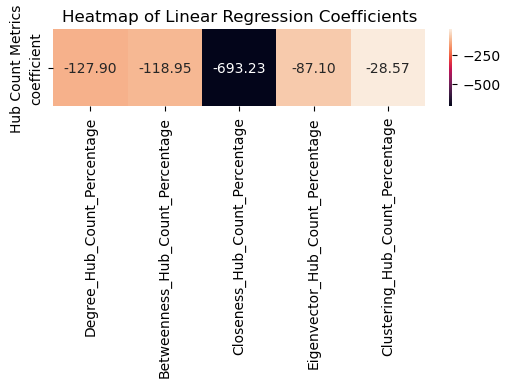

In [243]:
# Visualization of the contribution of coefficients
for hub_count in hub_counts:
    model = smf.ols(f"durationInSec ~ {hub_count}_Percentage", df_player[df_player.completion==1])
    result = model.fit()
    coefficients.loc[f'{hub_count}_Percentage', 'coefficient'] = result.params[f'{hub_count}_Percentage']
coefficients['coefficient'] = coefficients['coefficient'].astype(float)
coefficients_duration = coefficients
plt.figure(figsize=(6, 1))
sns.heatmap(coefficients.transpose(), annot=True, fmt=".2f")
plt.title('Heatmap of Linear Regression Coefficients')
plt.ylabel('Hub Count Metrics')
plt.show()

### Part 3: The player's fault or Wikispeedia's ?

Finally, we look at the influence of the source and target articles on the players' performance. In particular, we look if the source and target articles are in the same category and what is the shortest path between the two compared to the players' path. 

In [244]:
# Dictionnaries to store the main category of each article
article_to_categories = categories.groupby('Node')['main_cat'].apply(list).to_dict()

In [245]:
# Create a binary variable to say if source and target articles have the same category
df_player.loc[:, 'same_category'] = df_player.apply(
    lambda row: have_common_category(row['source'], row['target'], article_to_categories), axis=1)

In [246]:
# Fit the first model (including same_category)
model_with = smf.ols("completion ~ Closeness_Hub_Count_Percentage + shortest_path + same_category", df_player)
result_with = model_with.fit()

# Fit the second model (excluding same_category)
model_without = smf.ols("completion ~ Closeness_Hub_Count_Percentage + shortest_path", df_player)
result_without = model_without.fit()

# Extract R-squared, coefficients and p-values
data = {
    'Metrics': ['R-squared', 'Closeness_Hub_Count_Percentage', 'shortest_path', 'same_category'],
    'With same_category': [
        result_with.rsquared, 
        result_with.params['Closeness_Hub_Count_Percentage'], 
        result_with.params['shortest_path'], 
        result_with.params.get('same_category', 'N/A')  # 'N/A' if same_category is not in the model
    ],
    'Without same_category': [
        result_without.rsquared, 
        result_without.params['Closeness_Hub_Count_Percentage'], 
        result_without.params['shortest_path'],
        'N/A'  # same_category is not in this model
    ],
    'P-value (With)': [
        'N/A',
        result_with.pvalues['Closeness_Hub_Count_Percentage'],
        result_with.pvalues['shortest_path'],
        result_with.pvalues.get('same_category', 'N/A')
    ],
    'P-value (Without)': [
        'N/A',
        result_without.pvalues['Closeness_Hub_Count_Percentage'],
        result_without.pvalues['shortest_path'],
        'N/A'
    ]
}

comparison_table = pd.DataFrame(data)

# Display the table
display(comparison_table)

,Metrics,With same_category,Without same_category,P-value (With),P-value (Without)
0,R-squared,0.065138,0.064621,N/A,N/A
1,Closeness_Hub_Count_Percentage,0.349084,0.34945,0.0,0.0
2,shortest_path,-0.149759,-0.151442,0.0,0.0
3,same_category,0.029218,N/A,0.0,N/A


In [247]:
# Fit the first model (including same_category)
model_with = smf.ols("durationInSec ~ Closeness_Hub_Count_Percentage + shortest_path + same_category", df_player)
result_with = model_with.fit()

# Fit the second model (excluding same_category)
model_without = smf.ols("durationInSec ~ Closeness_Hub_Count_Percentage + shortest_path", df_player)
result_without = model_without.fit()

# Extract R-squared, coefficients and p-values
data = {
    'Metrics': ['R-squared', 'Closeness_Hub_Count_Percentage', 'shortest_path', 'same_category'],
    'With same_category': [
        result_with.rsquared, 
        result_with.params['Closeness_Hub_Count_Percentage'], 
        result_with.params['shortest_path'], 
        result_with.params.get('same_category', 'N/A')  # 'N/A' if same_category is not in the model
    ],
    'Without same_category': [
        result_without.rsquared, 
        result_without.params['Closeness_Hub_Count_Percentage'], 
        result_without.params['shortest_path'],
        'N/A'  # same_category is not in this model
    ],
    'P-value (With)': [
        'N/A',
        result_with.pvalues['Closeness_Hub_Count_Percentage'],
        result_with.pvalues['shortest_path'],
        result_with.pvalues.get('same_category', 'N/A')
    ],
    'P-value (Without)': [
        'N/A',
        result_without.pvalues['Closeness_Hub_Count_Percentage'],
        result_without.pvalues['shortest_path'],
        'N/A'
    ]
}

comparison_table = pd.DataFrame(data)

# Display the table
display(comparison_table)

,Metrics,With same_category,Without same_category,P-value (With),P-value (Without)
0,R-squared,0.036934,0.036711,N/A,N/A
1,Closeness_Hub_Count_Percentage,-596.650139,-596.990738,0.0,0.0
2,shortest_path,147.584253,149.152386,0.0,0.0
3,same_category,-27.222285,N/A,0.000027,N/A


In [248]:
# Fit models for comparison with/without Closeness_Hub_Count_Percentage
model_with_closeness = smf.ols("durationInSec ~ Closeness_Hub_Count_Percentage + shortest_path", df_player)
result_with_closeness = model_with_closeness.fit()

model_without_closeness = smf.ols("durationInSec ~ shortest_path", df_player)
result_without_closeness = model_without_closeness.fit()

# Extracting R-squared, coefficients, and p-values
comparison_data = {
    'Metrics': ['R-squared', 'Shortest path', 'Closeness Hub Percentage'],
    'With Hub %': [
        round(result_with_closeness.rsquared, 3),
        round(result_with_closeness.params['shortest_path'], 3),
        round(result_with_closeness.params['Closeness_Hub_Count_Percentage'], 3)
    ],
    'Without Hub %': [
        round(result_without_closeness.rsquared, 3),
        round(result_without_closeness.params['shortest_path'], 3),
        'N/A'
    ],
    'P-value (With Hub %)': [
        'N/A',
        round(result_with_closeness.pvalues['shortest_path'], 3),
        round(result_with_closeness.pvalues['Closeness_Hub_Count_Percentage'], 3)
    ],
    'P-value (Without Hub %)': [
        'N/A',
        round(result_without_closeness.pvalues['shortest_path'], 3),
        'N/A'
    ]
}

comparison_table = pd.DataFrame(comparison_data)
display(comparison_table)

,Metrics,With Hub %,Without Hub %,P-value (With Hub %),P-value (Without Hub %)
0,R-squared,0.037,0.03,N/A,N/A
1,Shortest path,149.152,156.418,0.0,0.0
2,Closeness Hub Percentage,-596.991,N/A,0.0,N/A
